In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt # create static, animated and interactive visualisations
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization, Activation
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

import glob, os, random, re

import pandas as pd 

import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

In [2]:
base_path = 'data'

img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

print("The total amount of images in the data is " , len(img_list)) 

The total amount of images in the data is  8233


In [3]:
categories = {0: 'arp', 1: 'baglama', 2: 'elektroGitar', 3: 'gitar', 4: 'kanun'
             , 5: 'keman', 6: 'kemence', 7: 'mandolin', 8: 'ud', 9: 'yayliTambur'}
# Etiket isimlerimizi belirliyoruz.
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

filenames_list = []
categories_list = []

for category in categories:
    filenames = os.listdir(base_path +'/' + categories[category])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('Görüntü Sayısı = ' , len(df))
df # show dataframe

Görüntü Sayısı =  8233


,filename,category
0,kanun(/kanun(158).jpg,4
1,gitar(/gitar(702).jpg,3
2,baglama(/baglama(936).jpg,1
3,baglama(/baglama(226).jpg,1
4,keman(/keman(567).jpg,5
...,...,...
8228,elektroGitar(/elektroGitar(1254).jpg,2
8229,arp(/arp(120).jpg,0
8230,elektroGitar(/elektroGitar(338).jpg,2
8231,elektroGitar(/elektroGitar(1344).jpg,2


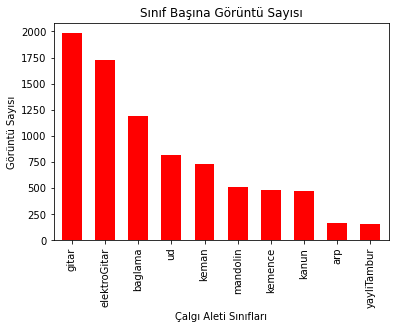

In [4]:
df_visualization = df.copy()
# Replace numerical category with names for labeling purpose
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category', color = 'red', width = 0.6)
# plot graph to show the number of images in each class
plt.title("Sınıf Başına Görüntü Sayısı")
plt.ylabel("Görüntü Sayısı")
plt.xlabel("Çalgı Aleti Sınıfları");

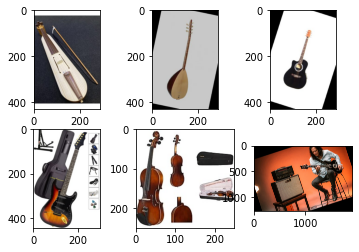

In [5]:
for i, img_path in enumerate(random.sample(img_list, 6)): # randomly pick 6 photos from the dataset
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=0
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

Found 6592 images belonging to 10 classes.
Found 1641 images belonging to 10 classes.
{0: 'arp', 1: 'baglama', 2: 'elektroGitar', 3: 'gitar', 4: 'kanun', 5: 'keman', 6: 'kemence', 7: 'mandolin', 8: 'ud', 9: 'yayliTambur'}


In [7]:
# Build Model
model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 32)       0

In [8]:
import tensorflow as tf

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='training/cp.ckpt',
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit_generator(train_generator, epochs=10,
                              validation_data=validation_generator, callbacks=[cp_callback])

<ipython-input-8-61e8d9233cc9>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=10, validation_data=validation_generator, callbacks=[cp_callback])


Epoch 1/10
 17/206 [=>............................] - ETA: 4:27 - loss: 2.1239 - acc: 0.2335

C:\Users\YakupAkdin\AppData\Roaming\Python\Python38\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


206/206 [==============================] - ETA: 0s - loss: 1.9258 - acc: 0.2814
Epoch 1: saving model to training\cp.ckpt
206/206 [==============================] - 328s 2s/step - loss: 1.9258 - acc: 0.2814 - val_loss: 1.6958 - val_acc: 0.3608
Epoch 2/10
206/206 [==============================] - ETA: 0s - loss: 1.6781 - acc: 0.4035
Epoch 2: saving model to training\cp.ckpt
206/206 [==============================] - 329s 2s/step - loss: 1.6781 - acc: 0.4035 - val_loss: 1.5356 - val_acc: 0.4784
Epoch 3/10
206/206 [==============================] - ETA: 0s - loss: 1.4878 - acc: 0.4882
Epoch 3: saving model to training\cp.ckpt
206/206 [==============================] - 334s 2s/step - loss: 1.4878 - acc: 0.4882 - val_loss: 1.3812 - val_acc: 0.5460
Epoch 4/10
206/206 [==============================] - ETA: 0s - loss: 1.3983 - acc: 0.5264
Epoch 4: saving model to training\cp.ckpt
206/206 [==============================] - 330s 2s/step - loss: 1.3983 - acc: 0.5264 - val_loss: 1.3212 - val_acc

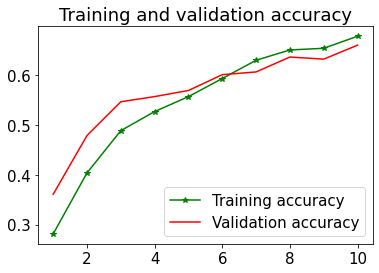

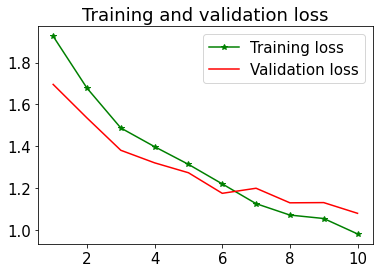

In [58]:
train_acc = history.history['acc'] # store training accuracy in history
val_acc = history.history['val_acc'] # store validation accuracy in history
train_loss = history.history['loss'] # store training loss in history
val_loss = history.history['val_loss'] # store validation loss in history

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'g*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'g*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

1/1 [==============================] - 0s 307ms/step
[3.0993816e-04 8.3135612e-02 2.8643575e-01 3.1702045e-02 3.3309178e-03
 1.7824505e-02 2.9377377e-02 4.4887552e-01 5.4937944e-02 4.4070445e-02]


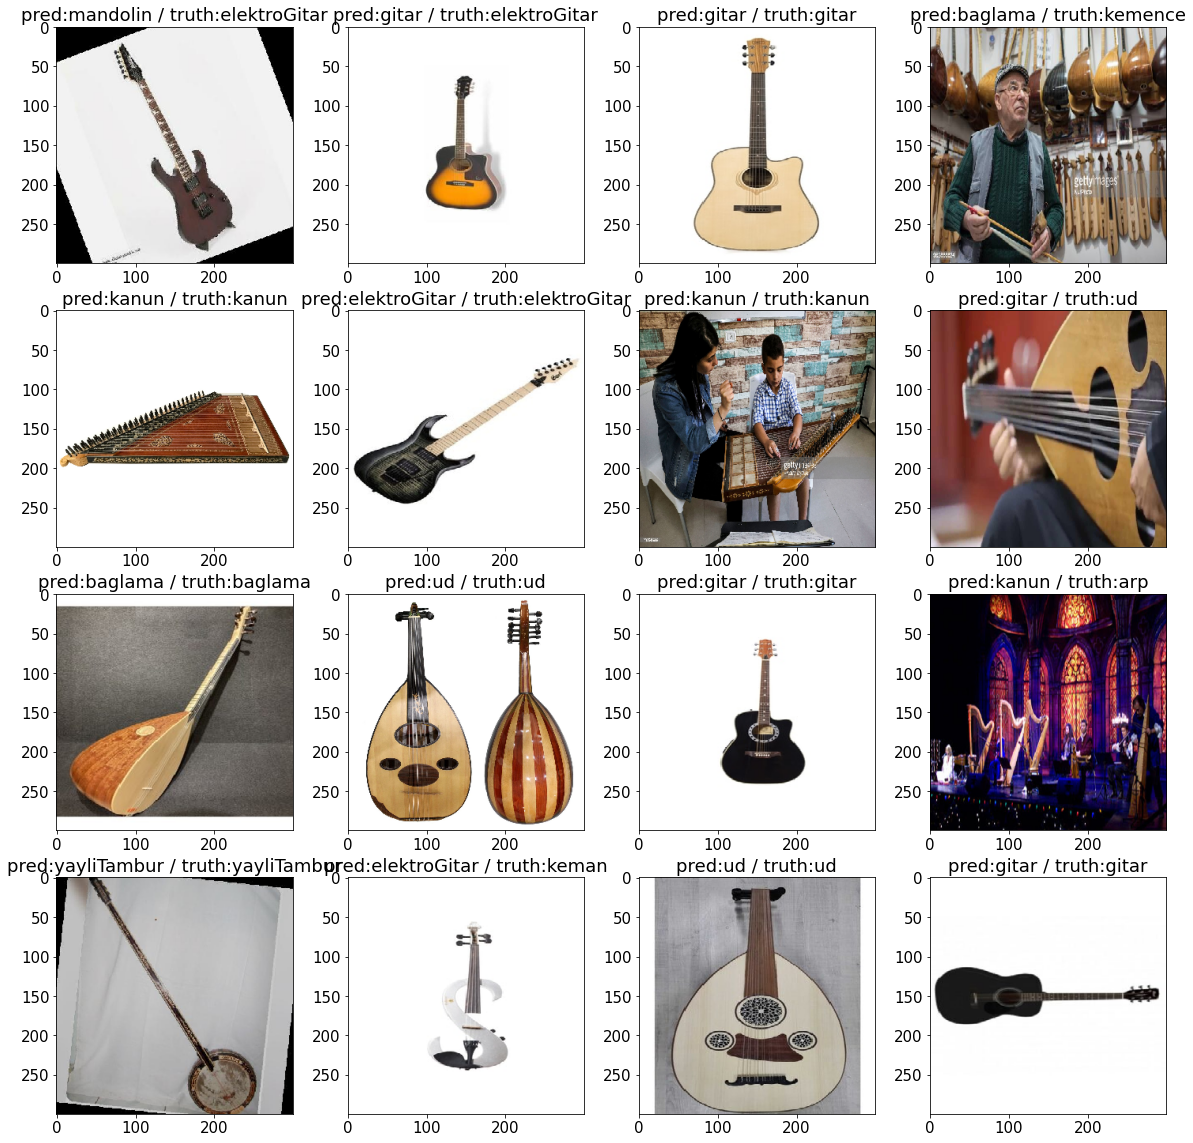

In [76]:
test_x, test_y = validation_generator.__getitem__(1)
# test_x - train data
# test_y - actual answer of the testing set data
# preds - predicted class
preds = model.predict(test_x)

print(preds[0])

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])
#show testing results

In [77]:
print("-- Evaluate --")
scores = model.evaluate_generator(validation_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --


<ipython-input-77-92ea95cd1814>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(validation_generator, steps=5)


acc: 60.62%


In [78]:
# show model details
test_true = np.argmax(test_y, axis=1)
test_pred = np.argmax(preds, axis=1)
print(classification_report(test_true, test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.80      0.80      0.80         5
           2       0.57      0.67      0.62         6
           3       0.71      0.71      0.71         7
           4       0.67      1.00      0.80         2
           5       1.00      0.50      0.67         2
           6       0.00      0.00      0.00         3
           7       0.33      1.00      0.50         1
           8       0.50      0.67      0.57         3
           9       1.00      0.50      0.67         2

    accuracy                           0.62        32
   macro avg       0.56      0.58      0.53        32
weighted avg       0.61      0.62      0.60        32



In [79]:
from sklearn.model_selection import train_test_split

#Change categories from numbers to names
df["category"] = df["category"].replace(categories) 

# Split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_validate , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  823 validate size =  823 test size =  824


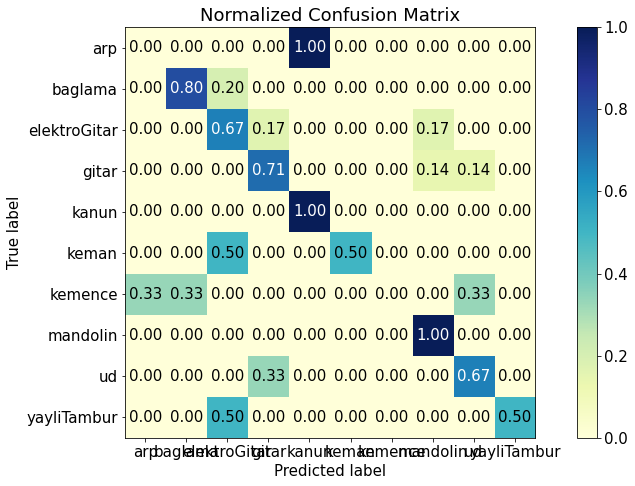

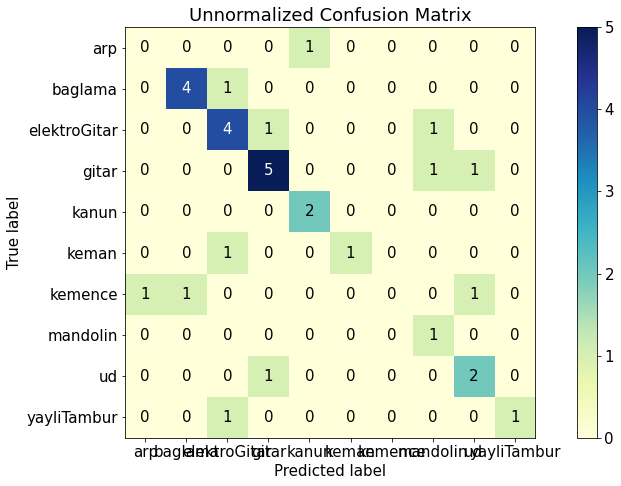

In [80]:
# produce the confusion matrix of the results (normalized)
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.YlGnBu):

    if not title: # set title based on normalize setting
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(test_true, test_pred)
    # Use labels that appear in data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Print table
    fig, ax = plt.subplots(figsize=(12,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # show all ticks and label with respective categories
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plt.rc('font', family='sans-serif', size=15)
classes = ['arp','baglama','elektroGitar','gitar','kanun','keman','kemence','mandolin','ud','yayliTambur']
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=classes, normalize=True, title='Normalized Confusion Matrix')
plt.show()
# Plot unnormalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=classes, normalize=False, title='Unnormalized Confusion Matrix')
plt.show()

In [81]:
# calculate accuracy of each class
from sklearn.metrics import confusion_matrix

predictions_one_hot = model.predict(test_x)
cm = confusion_matrix(test_true, test_pred)
print(cm)

1/1 [==============================] - 0s 312ms/step
[[0 0 0 0 1 0 0 0 0 0]
 [0 4 1 0 0 0 0 0 0 0]
 [0 0 4 1 0 0 0 1 0 0]
 [0 0 0 5 0 0 0 1 1 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0]
 [1 1 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 2 0]
 [0 0 1 0 0 0 0 0 0 1]]


In [83]:
# identify accuracy of each class 
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)


# Overall accuracy
print ("'arp','baglama','elektroGitar','gitar','kanun','keman','kemence','mandolin','ud','yayliTambur'")
ACC = (TP+TN)/(TP+FP+FN+TN)
print (ACC)

'arp','baglama','elektroGitar','gitar','kanun','keman','kemence','mandolin','ud','yayliTambur'
[0.9375  0.9375  0.84375 0.875   0.96875 0.96875 0.90625 0.9375  0.90625
 0.96875]
